***

### **Importante** 


- **Realice varios comentarios haciendo uso de una etiqueta html para darle color al comentario. Sin embargo, al subir mis notebooks a GITHUB las secciones donde realice los comentarios a color aparecen en blanco.**  

- **El "Enable Scrolling for Outputs" no se respeta al subir este contenido a GITHUB, por lo tanto, la impresión de los datos puede ser larga.**  

**Lo anterior no afecta en absoluto el contenido principal y el funcionamiento del documento, por lo que, si lo deseas, lo puedes ejecutar sin ningún problema en tu ordenador.**

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Creamos la función de activación RELU para las capas ocultas:
def relu(arreglo_sp):
    """Esta función aplica la activación RELU a nuestra suma ponderada."""
    arreglo_activaciones = np.zeros(shape=(arreglo_sp.shape))

    for fila in range(len(arreglo_sp)):
        for sp in range(arreglo_sp.shape[1]):
            arreglo_activaciones[fila,sp] = max(arreglo_sp[fila,sp],0)
  
    return arreglo_activaciones

In [3]:
# Softmax para la capa de salida:
def softmax(neuronas_de_salida):
    """Esta función aplica la (vaya la redundacia), función de activación Softmax a la capa de salida."""
    
    activaciones = np.zeros(shape=neuronas_de_salida.shape)
    
    for i,fila_neuronas in enumerate(neuronas_de_salida):
        activaciones[i,:] = np.exp(fila_neuronas) / sum([np.exp(neurona_de_salida) 
                                                         for neurona_de_salida in fila_neuronas])
        
    return activaciones

In [4]:
# Creamos una función para dar formato a las salidas:
def one_hot_encode(salidas,numero_de_clases):
    """Esta función le da formato one-hot encode a nuestras salidas. 
    Este es el formato de salidas usado por Softmax."""
    
    salidas_ = np.array(salidas)
    
    vector_salidas = np.zeros(shape=(salidas_.shape[0],numero_de_clases))
    
    for fila,salida in enumerate(salidas_):
        vector_salidas[fila,salida] += 1
        
    return vector_salidas

In [5]:
# Creamos una función para la realización de la suma ponderada y aplica la función de activación RELU:
def _suma_ponderada_(entradas,pesos,bias,i,cantidad_capas): # Entradas o Activaciones, dependiendo en que capa estemos.
    """Esta función realiza la suma ponderada de nuestros datos."""

    assert entradas.shape[1] == pesos.shape[0], "La cantidad de columnas de las entradas respecto del tamaño de las \
    cantidad de filas de los pesos, deben coincidir para llevara a cabo su producto matricial!"
    assert len(bias.shape) == 2 and bias.shape[0] == 1, "El formato de los bias debe ser en vector fila. Por lo tanto, debe \
    de tener 2 dimensiones!"
    assert pesos.shape[1] == bias.shape[1], "La cantidad de columnas que poseen los pesos debe ser igual a la cantidad \
    de columnas que posee el vector bias!"
    
    entradas_ = np.hstack((entradas,np.ones(shape=(len(entradas),1)))) # Agregamos el peso de cada Bias a las entradas.
    parametros_ = np.vstack((pesos,bias))
    
    # Suma ponderada, Entradas/Activación + parámetros:
    if i+1 == cantidad_capas: # Capa de Salida.
        return softmax(entradas_@parametros_)
    else: # Capas Ocultas.
        return relu(entradas_@parametros_)

In [6]:
#cantidad_capas = 2

# Creamos una función que realice la propagación hacia adelante (feedforwad):
def feedforward(salidas,entradas,pesos,bias,cantidad_capas):
    """Esta función realiza la propagación hacia adelante."""
    
    assert len(entradas.shape) == 2, "La matriz de entradas debe tener 2 dimensiones!"
    assert len(salidas.shape) == 2 and salidas.shape[1] >= 2, "Verifica que las salidas ya se encuentren \
    en el formato 'one-hot encode'!"
    
    
    activaciones = list()
    activaciones.append(entradas)
    for i in range(cantidad_capas): # Cada iteración representa una capa.
        entradas =  _suma_ponderada_(entradas,pesos[i],bias[i],i,cantidad_capas)
        activaciones.append(entradas)
        
    return activaciones

In [7]:
# Función de Error:
def entropia_cruzada(predicciones,salidas): # predicciones = activaciones[-1]
    """Esta función calcula el error de predicción de nuestra red neuronal."""
    
    prediccion = np.sum(predicciones*salidas,axis=1).reshape(-1,1) # Damos formato a vector columna.
    
    # Error = -ln(predicción)/total_datos:
    E = sum((-1)*(np.log(prediccion)))/len(salidas) # Promediamos el error.
    
    return E

In [8]:
#tamaño_lote = 2

# Backpropagation:
def backpropagation(activaciones,salidas,pesos,bias,tamaño_lote):
    """Esta función calcula los gradientes para las actualizaciones de los parámetros"""

    # Primero debemos calcular las deltas de las neuronas de las capas ocultas y la de la capa de salida:
    deltas_de_salida = activaciones[-1] - salidas # Activación Softmax en la capa de salida.

    deltas_totales = list()
    deltas_totales.append(deltas_de_salida)
    for pesos_x_capa,activacion_x_capa in zip(pesos[:0:-1],activaciones[-2:0:-1]):
        deltas_x_capa = list()
        for i,entrada_activacion in enumerate(activacion_x_capa):
            vector_deltas = list()
            for pesos_fila,activacion in zip(pesos_x_capa,entrada_activacion):
                if activacion > 0:
                    vector_deltas.append(pesos_fila@deltas_de_salida[i])
                else:
                    vector_deltas.append(0)
            deltas_x_capa.append(vector_deltas)
        deltas_x_capa = np.asarray(deltas_x_capa).reshape(activacion_x_capa.shape)
        deltas_totales.append(np.asarray(deltas_x_capa))
    deltas_totales.reverse()

    # Como segundo paso, procedemos a calcular el gradiente promedio por cada peso:
    gradientes_promedio = list() # Gradientes promedio para los pesos.

    for activacion_arreglo,deltas in zip(activaciones[-2::-1],deltas_totales[::-1]):
        error_delta = 0
        gradientes_x_capa = list()
        while (error_delta < deltas.shape[1]): # error_delta < columnas.
            selector = 0
            gradientes = list()
            while (selector < activacion_arreglo.shape[1]): # selector < columnas.
                gradientes.append((activacion_arreglo[:,selector]@deltas[:,error_delta])/tamaño_lote)
                selector += 1
            error_delta += 1
            gradientes_x_capa.append(gradientes)
        gradientes_x_capa = np.asarray(gradientes_x_capa).reshape(deltas.shape[1],-1).T
        gradientes_promedio.append(gradientes_x_capa)
    gradientes_promedio.reverse()

    # Finalimente, calculamos los gradientes, para los bias:
    gradientes_bias = list() # Gradientes promedio para los bias.

    for deltas in deltas_totales[::-1]:
        errores_delta = 0
        gradientes_bias_x_capa = list()
        while errores_delta < deltas.shape[1]:
            gradientes_bias_x_capa.append(sum(deltas[:,errores_delta])/tamaño_lote)
            errores_delta += 1
        gradientes_bias.append(np.asarray(gradientes_bias_x_capa))
    gradientes_bias.reverse()

    return gradientes_promedio,gradientes_bias

In [9]:
# Actualización de los parámetros:
def actualizacion_parametros(gradientes_pesos,gradientes_bias,pesos,bias,TA): # TA = Tasa de Aprendizaje.
    """Esta función actualiza nuestros parámetros."""
    
    pesos = [pesos_x_capa - TA*gradientes_x_capa for gradientes_x_capa,pesos_x_capa in zip(gradientes_pesos,pesos)]

    bias = [bias_x_capa - TA*gradientes_x_capa for gradientes_x_capa,bias_x_capa in zip(gradientes_bias,bias)]

    return pesos,bias

In [10]:
# Creamos una función para la realización de predicciones:
def predicciones(salidas,entradas,pesos,bias):
    """Esta función se encarga de realizar las predicciones deseadas."""
    
    for i in range(len(pesos)): # Cada iteración representa una capa.
        entradas =  _suma_ponderada_(entradas,pesos[i],bias[i],i,len(bias))
    
    arreglo_predicciones = np.zeros(shape=(len(entradas)))
    for i,probabilidad in enumerate(entradas):
        arreglo_predicciones[i] = [int(numero) for numero,prediccion in enumerate(probabilidad) 
                                   if prediccion == np.max(probabilidad)][0]
        
    return arreglo_predicciones

In [79]:
from timeit import default_timer
# Creamos una función para entrenar nuestro modelo:
def algoritmo_de_entrenamiento(entradas,salidas,tamaño_lote):
    """Esta función ejecuta el algoritmo de entrenamiento."""

    cantidad_lotes = str(len(entradas)/tamaño_lote).split('.')[-1]
    assert cantidad_lotes == '0', "El tamaño del lote debe ser divisor del total de la cantidad Datos!".upper()
    assert len(entradas.shape) == 2 and len(salidas.shape) == 2, "Los datos deben de tener al menos 2 dimensiones!"

    cantidad_capas = int(input("Hola, cuántas capas ocultas deseas? "))
    print("\nRecuerda que la ÚLTIMA CAPA OCULTA vendría siendo para nuestro caso la CAPA DE SALIDA")
    neuronas_x_capa = [int(input(f"Cuántas neuronas deseas para la capa oculta {capa+1}?: "))
                           for capa in range(cantidad_capas)]

    # Pedimos al usuario que ingrese la tasa de aprendizaje:
    texto = "Ingresa la tasa de aprendizaje. Rango válido: 0 < TA <= 1\n"
    TA = float(input(texto))

    # Creamos de manera aleatoria los parámetros (Pesos y Bias) entre 0 y 1:
    neuronas_x_capa.insert(0,entradas.shape[1])
    n_x_c = neuronas_x_capa.copy()
    pesos = [np.asarray([np.random.normal(0.0,0.5) for _ in range(n_x_c[i-1]*n_x_c[i])])*np.sqrt(2/(n_x_c[i-1]))
                 for i in range(1,len(n_x_c))]
    bias = [np.asarray([[0 for _ in range(n_x_c[i+1])]]) for i in range(len(n_x_c)-1)]

    # Ajustamos cada número de parámetros con su respectiva capa oculta y/o de salida:
    pesos = [pesos[i].reshape(n_x_c[i],n_x_c[i+1]) for i in range(len(pesos))]

    # Nos deshacemos del comodín usado en las neuronas por capa:
    del neuronas_x_capa[0]

    epocas = int(input("Cuántas épocas de entrenamiento deseas? "))
    error_minimo = float(input("Cuál es el error mínimo que deseas que logre el modelo? "))
    
    validar_datos = input("Deseas validar tu modelo en cada época? s/n")
    if validar_datos.lower() == 's':
        # Creamos una lista para almacenar el error de nuestro modelo en los datos de validación:
        Error_Validacion = list()
        # Creamos una lista para almacenar la precisión de nuestro modelo en los datos de validación:
        Precision_Validacion = list()
        # Generando datos de validación:
        datos_validacion = entradas[:10000]
        etiquetas_validacion = salidas[:10000]
        # Reorganizando los datos de entrada para evitar incluir los datos de validación:
        entradas = entradas[10000:]
        salidas = salidas[10000:]
        # Ahora, recargamos las etiquetas de los datos de salida en su formato original para medir la PRECISIÓN
        # de nuestro modelo en los datos de entrenamiento (no en los de validación):
        (_,Etiquetas_FO),(_,_) = mnist.load_data() # etiquetas_FO = Etiquetas en el Formato Original.
        etiquetas_VFO = Etiquetas_FO[:10000] # Etiquetas Validación en Formato Original.
        etiquetas_SFO = Etiquetas_FO[10000:] # Etiquetas Salida en Formato Orginal.
    else:
        (_,etiquetas_salida),(_,_) = mnist.load_data() # Etiquetas de salida en su formato original.
        
    Precision = []
    Error_x_Epoca = []

    lotes = len(entradas)//tamaño_lote
    print("\nCantidad de Lotes: {}\n".format(lotes))

    Tiempo_inicio = default_timer()

    for epoca in range(1,epocas+1):
        error_x_lote = 0
        i = 0

        for lote in range(lotes):
            activaciones = feedforward(salidas[i:i+tamaño_lote],entradas[i:i+tamaño_lote],pesos,bias,cantidad_capas)
            error_x_lote += entropia_cruzada(activaciones[-1],salidas[i:i+tamaño_lote])
            GP,GB = backpropagation(activaciones,salidas[i:i+tamaño_lote],pesos,bias,tamaño_lote)
            pesos,bias = actualizacion_parametros(GP,GB,pesos,bias,TA)
            i += tamaño_lote
            
        if validar_datos:
            prediccion_validacion = feedforward(etiquetas_validacion,datos_validacion,pesos,bias,cantidad_capas)
            error_validacion = entropia_cruzada(prediccion_validacion[-1],etiquetas_validacion)
            Error_Validacion.append(error_validacion) # Almacenamos los errores de validación.
            # Verificamos la precisión de nuestro modelo por época en los DATOS DE VALIDACIÓN:
            PV = predicciones(etiquetas_validacion,datos_validacion,pesos,bias)
            aciertos = (PV == etiquetas_VFO).sum() # Verificamos cantidad de aciertos.
            precision = (aciertos/len(datos_validacion))*100 # Calculamos la precisión de nuestra red.
            Precision_Validacion.append(precision)
        
        # Verificamos la PRECISIÓN de nuestro modelo por época en EL TOTAL DE LOS DATOS:
        prediccion_DE = predicciones(salidas,entradas,pesos,bias)
        if validar_datos:
            aciertos_DE = (prediccion_DE == etiquetas_SFO).sum() # Verificamos cantidad de aciertos.
        else:
            aciertos_DE = (prediccion_DE == etiquetas_salida).sum() # Verificamos cantidad de aciertos.
        precision_DE = (aciertos_DE/len(prediccion_DE))*100 # Calculamos la precisión de nuestra red.
        Precision.append(precision_DE)
        
        # Error Promedio del Total de los Datos por Época:
        error_promedio = error_x_lote/lotes
        Error_x_Epoca.append(error_promedio)
        
        if validar_datos:
            print(f"Error Promedio en Datos Entrenamiento: {error_promedio} | Error Validación: {error_validacion}")
            print(f"Precisión en Datos Entrenamiento: {precision_DE}% | Precisión en Validación: {precision}%")
            print('\r')
        else:
            print(f"Error Promedio en Datos Entrenamiento: {error_promedio} | Precisión en Datos Entrenamiento: {precision_DE}%")
            print('\r')
            
        if error_promedio <= error_minimo:
            Tiempo_final = default_timer()
            print(f"Error mínimizado en la Época: {epoca}")
            break

    Tiempo_final = default_timer()
    Tiempo_total = np.round(Tiempo_final - Tiempo_inicio,decimals=4)
    print("Tiempo Total: %s minutos"%(Tiempo_total/60))

    print(f"Época: {epoca}")

    return pesos,bias,Error_x_Epoca,Precision,Error_Validacion,Precision_Validacion

In [12]:
from keras.datasets import mnist

(datos_entrenamiento,etiquetas_entrenamiento), (datos_testeo,etiquetas_testeo) = mnist.load_data()

Using TensorFlow backend.


In [13]:
print(datos_entrenamiento.shape)
print(etiquetas_entrenamiento.shape)
print('\r')
print(datos_testeo.shape)
print(etiquetas_testeo.shape)

(60000, 28, 28)
(60000,)

(10000, 28, 28)
(10000,)


In [14]:
# Normalizamos el valor de nuestros datos de entrenamiento y testeo:
datos_entrenamiento = (datos_entrenamiento/np.max(datos_entrenamiento)).astype('float64')
datos_testeo = (datos_testeo/np.max(datos_testeo)).astype('float64')

In [15]:
# Damos formato a nuestras etiquetas:
etiquetas_entrenamiento = one_hot_encode(etiquetas_entrenamiento,10)
etiquetas_testeo = one_hot_encode(etiquetas_testeo,10)

print(etiquetas_entrenamiento.shape)
print(etiquetas_testeo.shape)

(60000, 10)
(10000, 10)


In [16]:
# Aplanamos las dimensiones de cada uno de nuestros datos:
datos_entrenamiento.resize(60000,28*28)
datos_testeo.resize(10000,28*28)

In [21]:
print(datos_entrenamiento.shape)
print(datos_testeo.shape)

(60000, 784)
(10000, 784)


In [34]:
pesos,bias,Er_DE,Psn_DE,Er_V,Psn_V = algoritmo_de_entrenamiento(datos_entrenamiento,etiquetas_entrenamiento,200)

Hola, cuántas capas ocultas deseas? 2

Recuerda que la ÚLTIMA CAPA OCULTA vendría siendo para nuestro caso la CAPA DE SALIDA
Cuántas neuronas deseas para la capa oculta 1?: 512
Cuántas neuronas deseas para la capa oculta 2?: 10
Ingresa la tasa de aprendizaje. Rango válido: 0 < TA <= 1
0.98
Cuántas épocas de entrenamiento deseas? 10
Cuál es el error mínimo que deseas que logre el modelo? 0.0001
Deseas validar tu modelo en cada época? s/ns

Cantidad de Lotes: 250

Error Promedio en Datos Entrenamiento: [0.38462526] | Error Validación: [0.18160618]
Precisión en Datos Entrenamiento: 94.676 | Precisión en Validación: 94.43

Error Promedio en Datos Entrenamiento: [0.12840848] | Error Validación: [0.12366518]
Precisión en Datos Entrenamiento: 96.896 | Precisión en Validación: 96.28

Error Promedio en Datos Entrenamiento: [0.08651719] | Error Validación: [0.10407332]
Precisión en Datos Entrenamiento: 97.7 | Precisión en Validación: 96.85000000000001

Error Promedio en Datos Entrenamiento: [0.0

**Gráficamos el desempeño de nuestra Red Neuronal:**

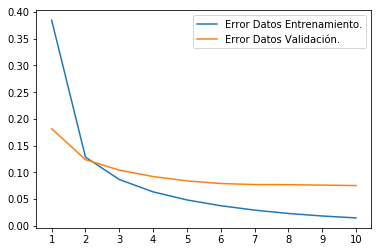

In [42]:
# Gráficamos los Errores:
epocas = range(1,len(Er_DE)+1)

plt.plot(epocas, Er_DE, label="Error Datos Entrenamiento.")
plt.plot(epocas, Er_V, label="Error Datos Validación.")
plt.xticks(epocas)
plt.xlabel("Época.")
plt.ylabel("Error.")
plt.legend()

plt.show()

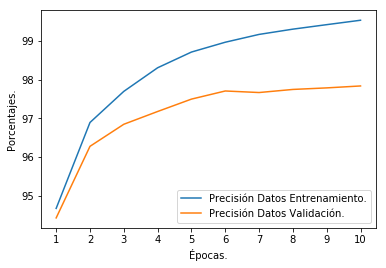

In [43]:
# Gráficamos los Aciertos:
plt.plot(epocas, Psn_DE, label="Precisión Datos Entrenamiento.")
plt.plot(epocas, Psn_V, label="Precisión Datos Validación.")
plt.xticks(epocas)
plt.ylabel("Precisión en %.")
plt.xlabel("Época.")
plt.legend()

plt.show()

**Realizamos las PREDICCIÓNES en los datos nunca vistos por el modelo:**

In [81]:
predicciones_ = predicciones(etiquetas_testeo,datos_testeo,pesos,bias) # Se realizan las predicciones.

In [82]:
# Recuperamos las etiquetas testeo nuevamente para verificar las predicciones:
(_,_), (_,etiquetas_testeo_verificacion) = mnist.load_data()

In [83]:
aciertos = (predicciones_ == etiquetas_testeo_verificacion).sum() # Verificamos cantidad de aciertos.
precision = (aciertos/len(datos_testeo))*100 # Calculamos la precisión de nuestra red.

print(f"Total de datos acertados: {aciertos} | Datos no acertados: {abs(aciertos-len(etiquetas_testeo_verificacion))}")
print(f"La precisión de nuestra red es del {precision}%")

Total de datos acertados: 9788 | Datos no acertados: 212
La precisión de nuestra red es del 97.88%


Como podemos observar, la precisión de nuestro modelo es bastante buena. Además, nuestra red no tiene overfitting (esto se puede observar en la gráfica de los errores). Por lo que sólo resta (en caso de que así lo requiera), entrenar sin datos de validación, es decir, con los 60000 datos completos en lugar de 50000 (debido a los datos que se tomaron como parte de la validación).

***

Para guardar los pesos:

In [122]:
import json

lista_pesos = [peso.tolist() for peso in pesos]

nombre_archivo = "pesos.json"
with open (nombre_archivo, 'w') as f_objeto:
    json.dump(lista_pesos,f_objeto)

Para cargar los pesos:

In [126]:
nombre_archivo = "pesos.json"
with open (nombre_archivo, 'r') as f_objeto:
    pesos_cargados = json.load(f_objeto)

In [130]:
pesos_cargados = [np.asarray(pesos_x_capa) for pesos_x_capa in pesos_cargados]

In [132]:
asdfg = predicciones(etiquetas_testeo_verificacion,datos_testeo,pesos_cargados,bias)

In [133]:
act = (asdfg == etiquetas_testeo_verificacion).sum() # Verificamos cantidad de aciertos.
psn = (act/len(datos_testeo))*100 # Calculamos la precisión de nuestra red.

print(f"La precisión de nuestra red es del {psn}%")

La precisión de nuestra red es del 97.88%
